In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import describe

In [11]:
def create_dataset(X, y):
    Xs, ys = [], []
    for i in range(len(X) - 1):
        Xs.append(X.iat[i])        
        ys.append(y.iat[i + 1])
    return np.array(Xs), np.array(ys)

def reject_outliers(data, m=2):
    t1 = abs(data - np.mean(data)) < m * np.std(data)
    return data[(np.where(t1 == True))[0]]

In [12]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

### Read the synchroized CGM data

In [13]:
data = pd.read_csv('data/cgm_to_meal_start.csv', parse_dates=['time_insulin', 'time_cgm'])
data = data.dropna()
data = data.reset_index(drop=True)

### Applying LSTM (a form of RNN) on a random subset of data

In [14]:
demo_data = data

DEMO_TRAIN_DATA_POINTS = 15000
FORECAST_POINTS = 1000

demo_train_start_idx = np.random.randint(0, len(demo_data) - DEMO_TRAIN_DATA_POINTS)
demo_train_end_idx = demo_train_start_idx + DEMO_TRAIN_DATA_POINTS

demo_train_data = demo_data[demo_train_start_idx : demo_train_end_idx]
demo_test_data = demo_data[demo_train_end_idx : demo_train_end_idx + FORECAST_POINTS]

In [15]:
train_data = demo_train_data['cgm']
test_data = demo_test_data['cgm']

In [16]:
X_train, y_train = create_dataset(train_data, train_data)
X_test, y_test = create_dataset(test_data, test_data)

X_train= X_train.reshape(len(X_train), 1, 1)
X_test = X_test.reshape(len(X_test), 1, 1)

model_cgm = keras.Sequential()
model_cgm.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]))) # batch_size * time_steps * num_features
model_cgm.add(keras.layers.Dense(1))
model_cgm.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))

fitted_model_cgm = model_cgm.fit(
    X_train, y_train, 
    epochs=150, 
    batch_size=32, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=False
)

y_pred = model_cgm.predict(X_test)

Epoch 1/150
422/422 [==============================] - 1s 2ms/step - loss: 21059.8418 - val_loss: 20606.7227
Epoch 2/150
422/422 [==============================] - 0s 1ms/step - loss: 12482.1299 - val_loss: 13257.9668
Epoch 3/150
422/422 [==============================] - 0s 1ms/step - loss: 7839.5942 - val_loss: 9130.3906
Epoch 4/150
422/422 [==============================] - 0s 1ms/step - loss: 5254.9683 - val_loss: 6604.4785
Epoch 5/150
422/422 [==============================] - 0s 1ms/step - loss: 3731.8452 - val_loss: 4981.0259
Epoch 6/150
422/422 [==============================] - 0s 1ms/step - loss: 2802.0024 - val_loss: 3889.2546
Epoch 7/150
422/422 [==============================] - 0s 1ms/step - loss: 2204.5173 - val_loss: 3123.1672
Epoch 8/150
422/422 [==============================] - 0s 1ms/step - loss: 1770.9509 - val_loss: 2567.2097
Epoch 9/150
422/422 [==============================] - 0s 1ms/step - loss: 1443.4254 - val_loss: 2157.1462
Epoch 10/150
422/422 [===========

422/422 [==============================] - 0s 1ms/step - loss: 207.2620 - val_loss: 232.0798
Epoch 79/150
422/422 [==============================] - 0s 1ms/step - loss: 204.5082 - val_loss: 225.8153
Epoch 80/150
422/422 [==============================] - 0s 1ms/step - loss: 203.2808 - val_loss: 226.9373
Epoch 81/150
422/422 [==============================] - 0s 1ms/step - loss: 204.1180 - val_loss: 224.0954
Epoch 82/150
422/422 [==============================] - 0s 1ms/step - loss: 204.9874 - val_loss: 228.6509
Epoch 83/150
422/422 [==============================] - 0s 1ms/step - loss: 201.3054 - val_loss: 223.0848
Epoch 84/150
422/422 [==============================] - 0s 1ms/step - loss: 200.8683 - val_loss: 222.4942
Epoch 85/150
422/422 [==============================] - 0s 1ms/step - loss: 200.6099 - val_loss: 223.8273
Epoch 86/150
422/422 [==============================] - 0s 1ms/step - loss: 202.0517 - val_loss: 227.2029
Epoch 87/150
422/422 [==============================] - 0s 

### Plot the predicted vs true CGM values

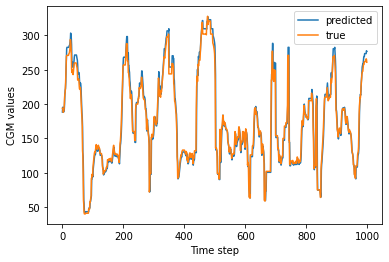

In [17]:
plt.plot(y_pred, label='predicted')
plt.plot(y_test, label='true')
plt.ylabel('CGM values')
plt.xlabel('Time step')
plt.legend()
plt.show()

## Finding the threshold for $|CGM_{predicted} - CGM_{actual}|$ empirically

In [19]:
K = 5
data_per_fold = 20000
train_percent = 0.70
all_meal_diff = []
all_non_meal_diff = []

for fold_no in range(K):
    fold_start_index = np.random.randint(0, len(data) - data_per_fold)
    fold_end_index = fold_start_index + data_per_fold
    
    fold_data = data[fold_start_index : fold_end_index]
    fold_train_end_index = int(train_percent * fold_data.__len__())
    fold_train_data = fold_data[0 : fold_train_end_index]
    fold_test_data = fold_data[fold_train_end_index : ]
    
    # extact no meal data for train data
    train_data = fold_train_data.loc[(fold_train_data['meal_start'] == 0) & (fold_train_data['meal'] == 0)]['cgm']
    # include both meal and no meal for test data
    test_data = fold_test_data['cgm']
    
    X_train, y_train = create_dataset(train_data, train_data)
    X_test, y_test = create_dataset(test_data, test_data)
    
    X_train= X_train.reshape(len(X_train), 1, 1)
    X_test = X_test.reshape(len(X_test), 1, 1)
    
    model_cgm = keras.Sequential()
    model_cgm.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]))) # batch_size * time_steps * num_features
    model_cgm.add(keras.layers.Dense(1))
    model_cgm.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))
    
    fitted_model_cgm = model_cgm.fit(
        X_train, y_train, 
        epochs=150, 
        batch_size=32, 
        validation_split=0.1, 
        verbose=0, 
        shuffle=False
    )
    
    y_pred = model_cgm.predict(X_test)
    
    # compute meal and no-meal differences here

    meal_diff = []
    non_meal_diff = []
    meal_truth = (fold_test_data['meal_start'] == 1).to_numpy()
    meal_indices = np.where(meal_truth == True)[0]
    non_meal_indices = np.where(meal_truth == False)[0]

    for idx in meal_indices:
        if idx < len(y_test):
            meal_diff.append(abs(y_pred[idx][0] - y_test[idx]))

    for idx in non_meal_indices:
        if idx < len(y_test):
            non_meal_diff.append(abs(y_pred[idx][0] - y_test[idx]))
    
    meal_diff = np.array(meal_diff)
    non_meal_diff = np.array(non_meal_diff)
    
    all_meal_diff.extend(meal_diff)
    all_non_meal_diff.extend(non_meal_diff)

### Plot the difference $|CGM_{predicted} - CGM_{actual}|$ for meal and non-meal points

TNR (non-meal -> non-meal) 0.6806666666666666
TPR (meal -> meal) 0.35064935064935066
FPR (non-meal -> meal) 0.31933333333333336
FNR (meal -> non-meal) 0.6806666666666666
Accuracy:  0.5934281510544385


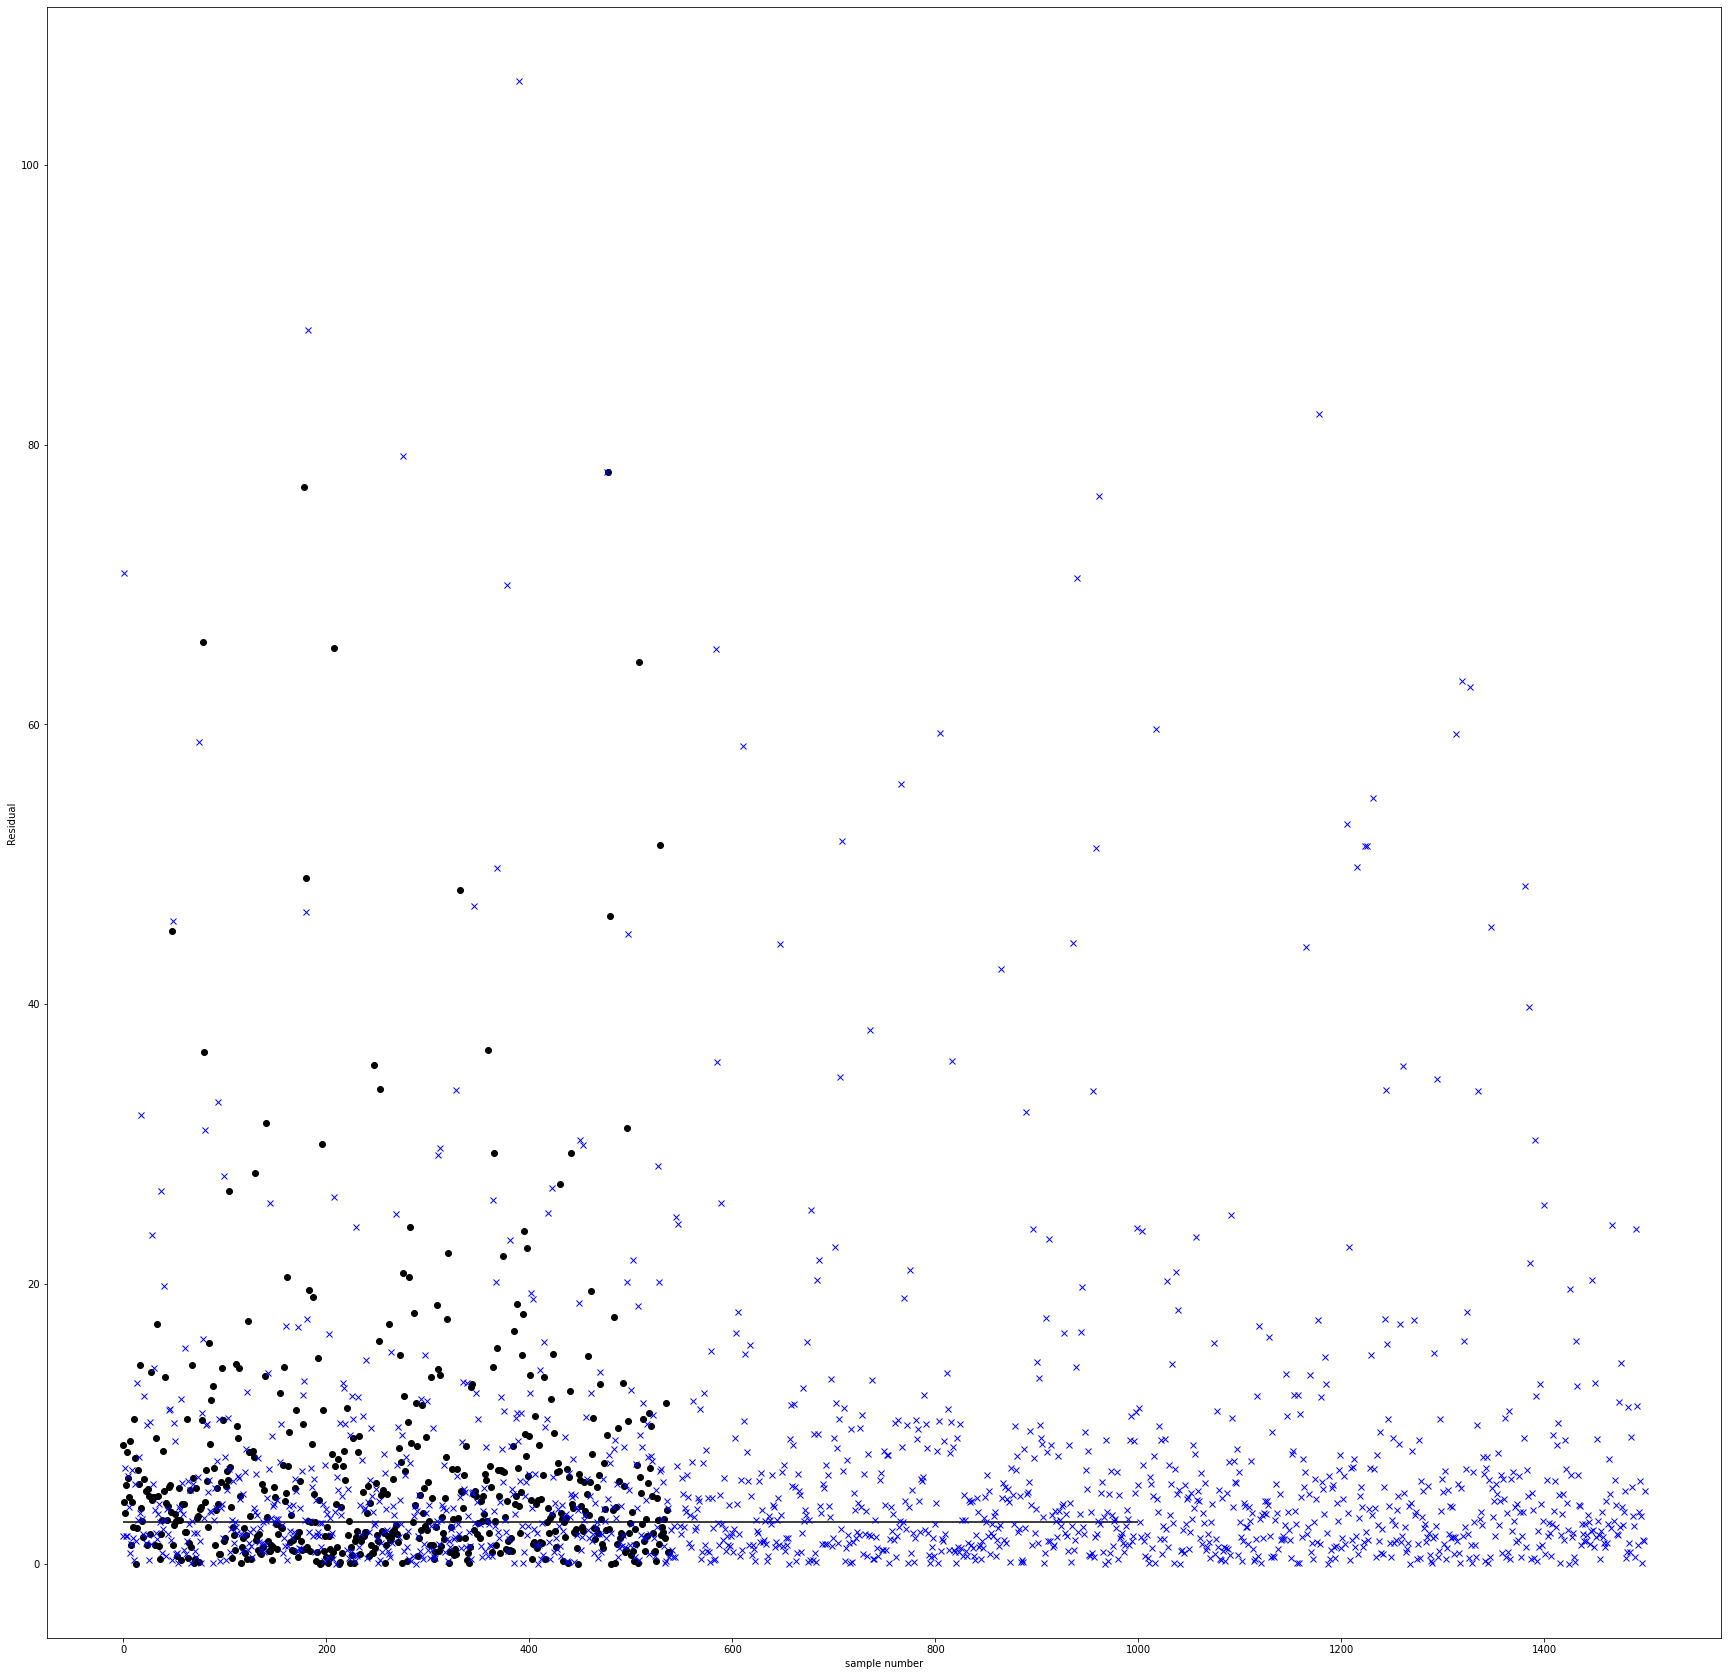

In [27]:
meal_diff = all_meal_diff
non_meal_diff = all_non_meal_diff
non_meal_diff = np.random.choice(non_meal_diff, 1500, replace=False)

plt.figure(figsize=(30, 30))
plt.plot(meal_diff, 'o', color='black')
plt.plot(non_meal_diff, 'x', color='blue')
plt.xlabel("sample number")
plt.ylabel("Residual")
plt.hlines(3.0, 0, 1000, color='black')

threshold = 5.5
non_meal_row = [non_meal_diff[non_meal_diff < threshold].__len__(), non_meal_diff[non_meal_diff >= threshold].__len__()]
meal_row = [meal_diff[meal_diff < threshold].__len__(), meal_diff[meal_diff >= threshold].__len__()]

true_positive = meal_diff[meal_diff >= threshold].__len__() / meal_diff.__len__()
true_negative = non_meal_diff[non_meal_diff < threshold].__len__() / non_meal_diff.__len__()

false_positive = non_meal_diff[non_meal_diff >= threshold].__len__() / non_meal_diff.__len__()
false_negative = meal_diff[meal_diff < threshold].__len__() / meal_diff.__len__()

true_positive = meal_diff[meal_diff >= threshold].__len__() / meal_diff.__len__()
true_negative = non_meal_diff[non_meal_diff < threshold].__len__() / non_meal_diff.__len__()

false_positive = non_meal_diff[non_meal_diff >= threshold].__len__() / non_meal_diff.__len__()
false_negative = meal_diff[meal_diff < threshold].__len__() / meal_diff.__len__()

print("TNR (non-meal -> non-meal)", true_negative)
print("TPR (meal -> meal)", true_positive)
print("FPR (non-meal -> meal)", false_positive)
print("FNR (meal -> non-meal)", true_negative)

detected_correctly = non_meal_diff[non_meal_diff < threshold].__len__() + meal_diff[meal_diff >= threshold].__len__()
total_points = meal_diff.__len__() + non_meal_diff.__len__()
accuracy = (detected_correctly) / (total_points)

print("Accuracy: ", accuracy )

## Evaluation on entire dataset by taking random K-folds over data


In [28]:
K = 25
data_per_fold = 15000
train_percent = 0.70
threshold = 5.5

all_true_positive = []
all_true_negative = []
all_false_positive = []
all_false_negative = []
all_accuracies = []


for fold_no in range(K):
    fold_start_index = np.random.randint(0, len(data) - data_per_fold)
    fold_end_index = fold_start_index + data_per_fold
    
    fold_data = data[fold_start_index : fold_end_index]
    fold_train_end_index = int(train_percent * fold_data.__len__())
    fold_train_data = fold_data[0 : fold_train_end_index]
    fold_test_data = fold_data[fold_train_end_index : ]
    
    # extact no meal data for train data
    train_data = fold_train_data.loc[(fold_train_data['meal_start'] == 0) & (fold_train_data['meal'] == 0)]['cgm']
    # include both meal and no meal for test data
    test_data = fold_test_data['cgm']
    
    X_train, y_train = create_dataset(train_data, train_data)
    X_test, y_test = create_dataset(test_data, test_data)
    
    X_train= X_train.reshape(len(X_train), 1, 1)
    X_test = X_test.reshape(len(X_test), 1, 1)
    
    model_cgm = keras.Sequential()
    model_cgm.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]))) # batch_size * time_steps * num_features
    model_cgm.add(keras.layers.Dense(1))
    model_cgm.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))
    
    fitted_model_cgm = model_cgm.fit(
        X_train, y_train, 
        epochs=150, 
        batch_size=32, 
        validation_split=0.1, 
        verbose=0, 
        shuffle=False
    )
    
    y_pred = model_cgm.predict(X_test)
    
    # compute meal and no-meal differences here

    meal_diff = []
    non_meal_diff = []
    meal_truth = (fold_test_data['meal_start'] == 1).to_numpy()
    meal_indices = np.where(meal_truth == True)[0]
    non_meal_indices = np.where(meal_truth == False)[0]

    for idx in meal_indices:
        if idx < len(y_test):
            meal_diff.append(abs(y_pred[idx][0] - y_test[idx]))

    for idx in non_meal_indices:
        if idx < len(y_test):
            non_meal_diff.append(abs(y_pred[idx][0] - y_test[idx]))
    
    meal_diff = np.array(meal_diff)
    non_meal_diff = np.array(non_meal_diff)
    
    print("#" * 10)
    print("FOLD NO: ", fold_no)
    true_positive = meal_diff[meal_diff >= threshold].__len__() / meal_diff.__len__()
    true_negative = non_meal_diff[non_meal_diff < threshold].__len__() / non_meal_diff.__len__()
    
    false_positive = non_meal_diff[non_meal_diff >= threshold].__len__() / non_meal_diff.__len__()
    false_negative = meal_diff[meal_diff < threshold].__len__() / meal_diff.__len__()
    
    print("TNR (non-meal -> non-meal)", true_negative)
    print("TPR (meal -> meal)", true_positive)
    print("FPR (non-meal -> meal)", false_positive)
    print("FNR (meal -> non-meal)", true_negative)
    
    detected_correctly = non_meal_diff[non_meal_diff < threshold].__len__() + meal_diff[meal_diff >= threshold].__len__()
    total_points = meal_diff.__len__() + non_meal_diff.__len__()
    accuracy = (detected_correctly) / (total_points)
    
    print("Accuracy: ", accuracy )
    
    print("#" * 10)
    
    all_true_positive.append(true_positive)
    all_true_negative.append(true_negative)
    all_false_positive.append(false_positive)
    all_false_negative.append(false_negative)
    all_accuracies.append(accuracy)

##########
FOLD NO:  0
TNR (non-meal -> non-meal) 0.6637268204432384
TPR (meal -> meal) 0.44155844155844154
FPR (non-meal -> meal) 0.33627317955676167
FNR (meal -> non-meal) 0.6637268204432384
Accuracy:  0.659924427650589
##########
##########
FOLD NO:  1
TNR (non-meal -> non-meal) 0.6849593495934959
TPR (meal -> meal) 0.38028169014084506
FPR (non-meal -> meal) 0.3150406504065041
FNR (meal -> non-meal) 0.6849593495934959
Accuracy:  0.680151144698822
##########
##########
FOLD NO:  2
TNR (non-meal -> non-meal) 0.6405967450271248
TPR (meal -> meal) 0.44
FPR (non-meal -> meal) 0.35940325497287523
FNR (meal -> non-meal) 0.6405967450271248
Accuracy:  0.637252722827295
##########
##########
FOLD NO:  3
TNR (non-meal -> non-meal) 0.4742314647377939
TPR (meal -> meal) 0.5066666666666667
FPR (non-meal -> meal) 0.5257685352622061
FNR (meal -> non-meal) 0.4742314647377939
Accuracy:  0.4747721715936875
##########
##########
FOLD NO:  4
TNR (non-meal -> non-meal) 0.5040760869565217
TPR (meal -> mea

### Average Metrics

In [29]:
print("TNR (non-meal -> non-meal)", np.mean(true_negative))
print("TPR (meal -> meal)", np.mean(true_positive))
print("FPR (non-meal -> meal)", np.mean(false_positive))
print("FNR (meal -> non-meal)", np.mean(true_negative))
print("Accuracy: ", np.mean(accuracy) )

TNR (non-meal -> non-meal) 0.6863100634632819
TPR (meal -> meal) 0.41379310344827586
FPR (non-meal -> meal) 0.31368993653671806
FNR (meal -> non-meal) 0.6863100634632819
Accuracy:  0.6810402311624806
